In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pydrake.all import MathematicalProgram, Variables, SolutionResult

In [3]:
# numeric parameters
m = 1.
l = 1.
g = 10.
b = .1

In [4]:
# optimization problem
prog = MathematicalProgram()

In [5]:
# dynamics in redundant coordinate system, x = [sin(theta), cos(theta), d(theta)/dt]'
nx = 3
x = prog.NewIndeterminates(nx, 'x')
dynamics = np.array([
    x[1] * x[2],                       # d(sin(theta))/dt
    - x[0]*x[2],                       # d(cos(theta))/dt
    - (b*x[2] + m*g*l*x[0]) / (m*l**2) # d2(theta)/dt2
])
x0 = np.array([0., 1., 0.])            # x(t=td=0)
constraint_set = x[0]**2 + x[1]**2 - 1.

In [6]:
def offset_function(prog, x, d, gamma=.01):
    """
    Returns the function
    phi(x) = sum_{i=1}^nx sum_{j=1}^{d/2} eps_ij x_i^(2j)
    where:
    d is the degree of the Lyapunov function V(x),
    x are the indeterminates of the polynomial,
    gamma > 0 is a tolerance value.
    The auxiliary optimization variables eps_ij >= 0 are subject to the constraint (for all i)
    sum_{j=1}^{d/2} eps_ij >= gamma
    This ensures that the condition
    V(x) - phi(x) >= 0
    implies V(x) radially unbounded and allows the optimizer to choose any degree for phi(x).
    Reference:
    Papachristodoulou, Prajna - Analysis of Non-polynomial Systems using the Sum of Squares Decomposition.
    """
    assert(d % 2 == 0)
    eps = prog.NewContinuousVariables(x.shape[0], d/2, 'eps')
    phi = 0.
    for i in range(x.shape[0]):
        prog.AddLinearConstraint(np.sum(eps[i,:]) >= gamma)
        for j in range(d/2):
            prog.AddLinearConstraint(eps[i,j] >= 0.)
            phi += eps[i,j]*x[i]**(2.*(j+1))
    return phi

In [7]:
# Lyapunov function V
V_degree = 2
V = prog.NewFreePolynomial(Variables(x), V_degree)
phi = offset_function(prog, x-x0, V_degree)
prog.AddSosConstraint(V.ToExpression() - phi)

(<pydrake.solvers._mathematicalprogram_py.Binding_PositiveSemidefiniteConstraint at 0x7fb3dec017f0>,
 <pydrake.solvers._mathematicalprogram_py.Binding_LinearEqualityConstraint at 0x7fb3dec01b30>)

In [8]:
# V(t=0, td=0) = (s=0, c=1, td=0) = 0
V_0 = V.ToExpression().EvaluatePartial({x_i: x0[i] for i, x_i in enumerate(x)})
prog.AddLinearConstraint(V_0 == 0.)

In [9]:
# V(t=pi, td=0) = V(s=0, c=-1, td=0) = 2mgl
# (to match the value of the mechanical energy)
V_pi = V.ToExpression().EvaluatePartial({x[0]: 0., x[1]: -1., x[2]: 0.})
prog.AddLinearConstraint(V_pi == 2. * m * g * l)

In [10]:
# multipliers for S-procedure
lam_degree = 2
lam = prog.NewFreePolynomial(Variables(x), lam_degree)

In [11]:
# time derivative of the Lyapunov function
Vdot = V.ToExpression().Jacobian(x).dot(dynamics)
prog.AddSosConstraint(- Vdot + lam.ToExpression() * constraint_set)

(<pydrake.solvers._mathematicalprogram_py.Binding_PositiveSemidefiniteConstraint at 0x7fb3dec01e70>,
 <pydrake.solvers._mathematicalprogram_py.Binding_LinearEqualityConstraint at 0x7fb3dec01ab0>)

In [12]:
# solve feasibility SDP
result = prog.Solve()
assert(result == SolutionResult.kSolutionFound)

In [13]:
# evaluate lyapunov function at the solution
V_opt = prog.SubstituteSolution(V)
def lyapunov(t, td):
    return V_opt.Evaluate({x[0]: np.sin(t), x[1]: np.cos(t), x[2]: td})

In [14]:
# total energy level sets
def energy(t, td):
    kinetic = .5 * (m * l**2) * td**2
    potential = m * g * l * (1. - np.cos(t))
    return kinetic + potential

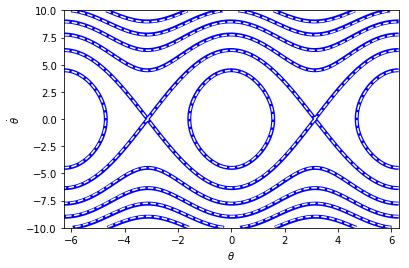

In [29]:
# plot Lyapunov function vs mechanical energy
n = 201
t = np.linspace(-2. * np.pi, 2. * np.pi, n)
td = np.linspace(-10., 10., n)
T, Td = np.meshgrid(t, td)
V_plot = np.array([lyapunov(t, td) for t, td in zip(np.ravel(T), np.ravel(Td))]).reshape(n, n)
E_plot = np.array([energy(t, td) for t, td in zip(np.ravel(T), np.ravel(Td))]).reshape(n, n)
plt.contour(T, Td, V_plot, colors='b', linewidths=4)
plt.contour(T, Td, E_plot, colors='w', linestyles='dashed')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot \theta$')
plt.show()